In [5]:
import sys
from hypecommons import *

init_experiment(osys='Windows')

# Code

In [6]:
def ema(data, n):
    alpha = 2 / (1 + n)
    return data.ewm(alpha=alpha, adjust=False).mean()

def rsi(data, n):
    # Make the positive gains (up) and negative gains (down) Series
    delta = data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    # Calculate the EWMA
    roll_up1 = up.ewm(span=n).mean()
    roll_down1 = down.abs().ewm(span=n).mean()

    # Calculate the RSI based on EWMA
    rs1 = roll_up1 / roll_down1
    return 100.0 - (100.0 / (1.0 + rs1))

def get_oscillator(data, field, window=50):
    win_50 = data[field].rolling(window=window)
    max_values = win_50.max()
    min_values = win_50.min()
    osc = []
    for max_value, min_value, value in zip(max_values, min_values, data[field]):
        if max_value == min_value:
            osc.append(50.0)
        else:
            osc.append(100.0 * (value - min_value) / (max_value - min_value))
    return osc

def round_to_3(x):
    return round(x, 3)

def technical_analysis(df, freq):
    df['change_norm_1'] = 100.0 * df['close'].diff() / df['close'].shift(1)

    df['ma50'] = df['close'].rolling(window=50).mean()
#     df['ma200'] = df['close'].rolling(window=200).mean()
    df['price_osc200'] = get_oscillator(df, 'close', window=200)
    df['price_osc200_diff'] = df['price_osc200'].diff().map(round_to_3)

    df['ema12'] = ema(df['close'], 12)
    df['ema26'] = ema(df['close'], 26)
    df['macd'] = df['ema12'] - df['ema26']
    df['signal'] = ema(df['macd'], 9)
    df['macd_histo'] = df['macd'] - df['signal']
    df['macd_histo_diff'] = df['macd_histo'].diff()

    boll = df['close'].rolling(window=20)
    boll_2std = 2.0 * boll.std()
    df['bollinger_low'] = boll.mean() - boll_2std
    df['bollinger_mid'] = boll.mean()
    df['bollinger_high'] = boll.mean() + boll_2std
    del boll, boll_2std

    df['rsi14'] = rsi(df['close'], 14)

#     low5 = df['low'].rolling(window=5).min()
#     df['rsv'] = 100.0 * (df['close'] - low5) / (df['high'].rolling(window=5).max() - low5)
#     del low5
#     df.loc[df['rsv'].isnull(), 'rsv'] = 50 # when max=min, the RSV is halfway up
#     df['kdj_k'] = df['rsv'].rolling(window=3).mean()
#     df['kdj_d'] = df['kdj_k'].rolling(window=3).mean()
#     df['kdj_j'] = 3.0 * df['kdj_k'] - 2.0 * df['kdj_d']

#     df['kdj_osc'] = 100.0 - abs(df['kdj_k'] - df['kdj_d']) # crosses at 99-100

#     df['volume_msum3'] = df['volume'].rolling(window=3).sum() # accumulated volumes
#     df['volume_osc'] = get_oscillator(df, 'volume')
#     df['volume_msum3_osc'] = get_oscillator(df, 'volume_msum3')

#     df['trades_msum3'] = df['trades'].rolling(window=3).sum() # accumulated trades
#     df['trades_osc'] = get_oscillator(df, 'trades')
#     df['trades_msum3_osc'] = get_oscillator(df, 'trades_msum3')

    df['bollinger_low_norm'] = 200.0 - 100.0 * df['low'] / df['bollinger_low'] # breaks above 100
    df['bollinger_high_norm'] = 100.0 * df['high'] / df['bollinger_high']      # breaks above 100

    df['macd_histo_norm'] = 50000.0 * df['macd_histo'] / df['ma50'] * (freq ** (-1/2)) # ideally in [-100, +100]
#     df['macd_histo_norm'] = 100/5 * (df['macd_histo'] - df['macd_histo'].rolling(window=50).mean()
#                                  ) / df['macd_histo'].rolling(window=50).std() # ideally in [-100, +100]
#     df['macd_histo_norm_diff'] = df['macd_histo_norm'].diff()
    
#     df['is_upward'] = df['macd_histo_norm_diff'] > 0
#     df['is_accel_upward'] = df['macd_histo_norm_diff'].diff() > 0

In [7]:
def apply_fees(x):
    return x * (1 - FEES)

# return row['price_osc200'] < 50 and row['is_negative'] and row['is_upward'] and row['macd_histo_norm'] < macd_thr[0]
# return not row['is_negative'] and not row['is_upward'] and row['macd_histo_norm'] > macd_thr[1]

def buy_signal(row, macd_thr, stake, last_sell_close, last_sell_elapsed, profit_rate):
    # if price (1) is below average and (2) is going down and (3) is accelerating up and (4) MACD histogram is below thr_0
    return row['macd_histo_norm'] <= macd_thr[0]

def sell_signal(row, macd_thr, stake, last_buy, last_buy_elapsed, profit):
    # if price (1) is going up and (2) is accelerating down and (3) MACD histogram is above thr_1
    return row['macd_histo_norm'] >= macd_thr[1] #or profit <= -0.02 * last_buy


def simulate(df, macd_thr):
    df['action'] = None
    df['prev_close'] = df['close'].shift(1)
    df['stake'] = None
    df['profits'] = None
    df['last_buy'] = None
    df['last_sell'] = None

    invested = False
    last_buy = 1
    last_sell_close = 0
    last_sell_elapsed = last_buy_elapsed = 0
    profits, last_buys, last_sells = [], [], []
    stakes = []
    actions = []
    stake = 1

    # important: only access constant values with row[]
    for i, (index, row) in enumerate(df.iterrows()):
        # stake accrued
        if invested:
            stake = stake / row['prev_close'] * row['close']
        profit_if_sell = apply_fees(stake) - last_buy
        profit_rate_if_buy = last_sell_close - row['close'] - row['close'] * FEES
        # follow action
        if buy_signal(row, macd_thr, stake, last_sell_close, last_sell_elapsed, profit_rate_if_buy) and not invested:
            action = 'BUY'
            stake = apply_fees(stake)
            invested = True
            profits.append(None)
            last_buy = stake
            last_buys.append(last_buy)
            last_sells.append(0)
            last_sell_elapsed += 1
            last_buy_elapsed = 0
        elif sell_signal(row, macd_thr, stake, last_buy, last_buy_elapsed, profit_if_sell) and invested:
            action = 'SELL'
            stake = apply_fees(stake)
            invested = False
            profits.append(profit_if_sell)
            last_sell_close = row['close']
            last_sells.append(last_sell_close)
            last_buys.append(0)
            last_sell_elapsed = 0
            last_buy_elapsed += 1
        else:
            action = '----'
            profits.append(None)
            last_buys.append(0)
            last_sells.append(0)
            last_sell_elapsed += 1
            last_buy_elapsed += 1
        stakes.append(stake)
        actions.append(action)
    
    df['stake'] = stakes
    df['action'] = actions
    df['profits'] = profits
    df['last_buy'] = last_buys
    df['last_sell'] = last_sells
    del df['prev_close']
        
    close0 = df['close'].iloc[0]
    df['hold'] = df['close'] / close0
    final_stake = df['stake'].iloc[-1]
    final_hold = df['hold'].iloc[-1]
    
    stats = {'stake_hold_rate': round(final_stake / final_hold, 3), 
             'stake': round(final_stake, 3), 'hold': round(final_hold, 3), 
             'profit_count': len(df[df['profits'] > 0]), 'loss_count': len(df[df['profits'] < 0])}
    
    return df, stats

In [8]:
from datetime import timedelta

def get_scores(stake_hold_rates):
    rob = 0
    pot = 1
    for k in stake_hold_rates:
        rob = rob + 1 if k >= 1.0 else rob
        pot = pot * k
    rob = int(100 * rob / len(stake_hold_rates))
    pot = round(pot, 3)
    return {'robustness': rob, 'potential': pot}

def trace(string, verbose=True):
    if verbose:
        print(string)

def single_run(symbol, start, freq, days, macd_thr, displ=True, verbose=True):
    df = download_history_fast(symbol, start, freq=freq, days=days)
    technical_analysis(df, freq)
    df.dropna(inplace=True)
    trace(f"MACD thr: {macd_thr}", verbose=verbose)
    df, stats = simulate(df, macd_thr)
    trace(stats, verbose=verbose)
    if displ:
        output_chart(df, symbol, freq)
        display_whole(df[df['action'] != '----'][
            ['action', 'rsi14', 'bollinger_low_norm', 'bollinger_high_norm', 
             'price_osc200', 'price_osc200_diff', 'macd_histo_norm', 'profits']])
    return df, stats

# Simulations

In [5]:
START = '20210402000000'
FREQ = 5
DAYS = 37

<img src='../../img/symbols/BTC.png' width='96' style="vertical-align: middle;"/>

## BTC

```
[-60, 70]
File BTCBUSD-20210402000000-5-37.json found.
weeks 1-5: 1.103  {'stake': 1.089, 'hold': 0.987, 'profit_count': 0, 'loss_count': 1}
weeks 2-5: 1.075  {'stake': 1.089, 'hold': 1.013, 'profit_count': 0, 'loss_count': 1}
weeks 3-5: 1.175  {'stake': 1.089, 'hold': 0.927, 'profit_count': 0, 'loss_count': 1}
weeks 4-5: 1.049  {'stake': 1.188, 'hold': 1.132, 'profit_count': 0, 'loss_count': 0}
weeks 5-5: 0.910  {'stake': 1, 'hold': 1.099, 'profit_count': 0, 'loss_count': 0}
```

MACD thr: [-60, 70]
weeks 1-5: 1.118  {'stake_hold_rate': 1.117, 'stake': 1.103, 'hold': 0.987, 'profit_count': 0, 'loss_count': 1}
weeks 2-5: 1.089  {'stake_hold_rate': 1.089, 'stake': 1.103, 'hold': 1.013, 'profit_count': 0, 'loss_count': 1}
weeks 3-5: 1.190  {'stake_hold_rate': 1.19, 'stake': 1.103, 'hold': 0.927, 'profit_count': 0, 'loss_count': 1}
weeks 4-5: 1.049  {'stake_hold_rate': 1.049, 'stake': 1.188, 'hold': 1.132, 'profit_count': 0, 'loss_count': 0}
weeks 5-5: 0.910  {'stake_hold_rate': 0.91, 'stake': 1, 'hold': 1.099, 'profit_count': 0, 'loss_count': 0}
{'robustness': 80, 'potential': 1.382}


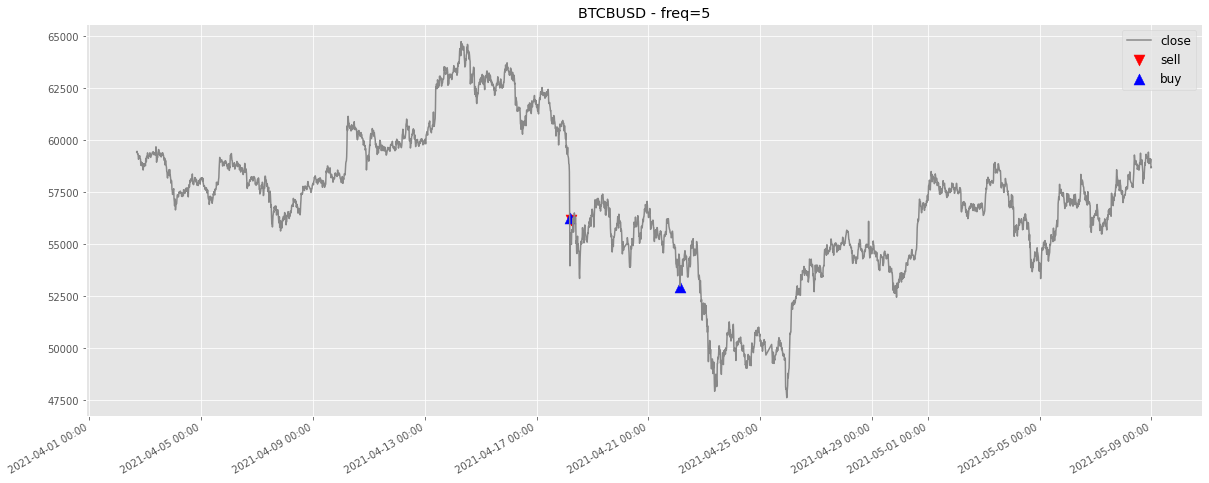

,action,rsi14,bollinger_low_norm,bollinger_high_norm,price_osc200,price_osc200_diff,macd_histo_norm,profits
2021-04-18 04:20:00,BUY,7.505659,104.087442,95.700127,0.000000,0.000,-66.615027,NaN
2021-04-18 05:30:00,SELL,57.441835,93.372743,94.456195,38.739458,7.076,84.427092,-0.002827
2021-04-22 03:15:00,BUY,16.518049,100.320502,96.613107,0.395215,-1.940,-61.388535,NaN


In [11]:
_ = study(symbol='BTCBUSD', start=START, freq=FREQ, days=DAYS, macd_thr=[-60, 70])
# for a in range(30, 101, 10):
#     for b in range(30, 101, 10):
#         macd_thr = [-a, b]
#         print((-a, b))
#         study(displ=False)

<img src='../../img/symbols/BNB.png' width='96' style="vertical-align: middle;"/>

## BNB

```
[-40, 90]
File BNBBUSD-20210402000000-5-37.json found.
weeks 1-5: 1.299  {'stake': 2.403, 'hold': 1.85, 'profit_count': 7, 'loss_count': 6}
weeks 2-5: 1.196  {'stake': 1.844, 'hold': 1.542, 'profit_count': 6, 'loss_count': 6}
weeks 3-5: 1.231  {'stake': 1.454, 'hold': 1.181, 'profit_count': 5, 'loss_count': 4}
weeks 4-5: 1.002  {'stake': 1.258, 'hold': 1.256, 'profit_count': 1, 'loss_count': 1}
weeks 5-5: 1.006  {'stake': 1.092, 'hold': 1.086, 'profit_count': 0, 'loss_count': 0}
```

MACD thr: [-40, 100]
weeks 1-5: 1.175  {'stake_hold_rate': 1.175, 'stake': 2.173, 'hold': 1.85, 'profit_count': 5, 'loss_count': 3}
weeks 2-5: 1.087  {'stake_hold_rate': 1.086, 'stake': 1.676, 'hold': 1.542, 'profit_count': 4, 'loss_count': 3}
weeks 3-5: 1.192  {'stake_hold_rate': 1.192, 'stake': 1.408, 'hold': 1.181, 'profit_count': 3, 'loss_count': 3}
weeks 4-5: 1.000  {'stake_hold_rate': 1.0, 'stake': 1.256, 'hold': 1.256, 'profit_count': 1, 'loss_count': 1}
weeks 5-5: 1.006  {'stake_hold_rate': 1.006, 'stake': 1.092, 'hold': 1.086, 'profit_count': 0, 'loss_count': 0}
{'robustness': 100, 'potential': 1.53}


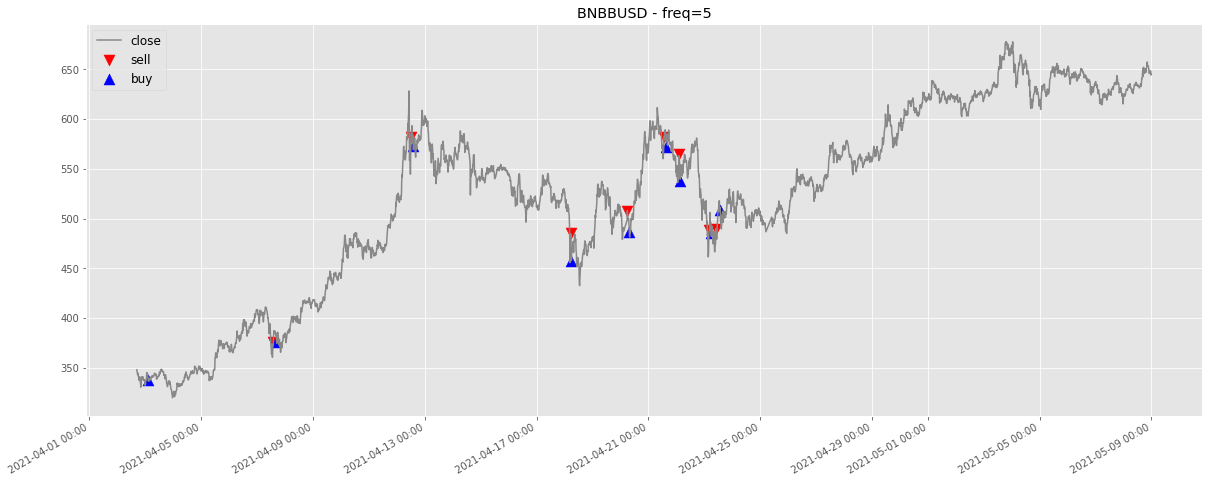

,action,rsi14,bollinger_low_norm,bollinger_high_norm,price_osc200,price_osc200_diff,macd_histo_norm,profits
2021-04-03 02:35:00,BUY,26.022622,99.956218,97.891352,37.959846,-7.090,-46.118083,NaN
2021-04-07 13:45:00,SELL,63.735805,96.804677,99.617818,29.139407,3.276,105.411401,0.111370
2021-04-07 16:30:00,BUY,22.014858,100.801446,97.997054,30.382539,-9.838,-56.230850,NaN
2021-04-12 12:15:00,SELL,63.664560,93.995503,99.592788,63.234998,-2.541,107.053231,0.603653
2021-04-12 14:00:00,BUY,34.126036,100.249280,97.576159,55.355233,-4.946,-48.422611,NaN
2021-04-18 05:30:00,SELL,55.528645,92.824245,95.463245,40.515812,1.918,101.264537,-0.262147
2021-04-18 05:55:00,BUY,28.027437,98.806940,93.019643,2.653355,1.981,-49.959755,NaN
2021-04-20 05:55:00,SELL,83.771010,94.656889,100.585938,55.577580,7.756,107.892576,0.156579
2021-04-20 07:35:00,BUY,24.524718,100.588368,97.177742,15.097923,-15.452,-57.490500,NaN
2021-04-21 13:25:00,SELL,70.881425,95.433757,100.300823,46.271360,0.307,100.867745,0.310462


In [12]:
_ = study(symbol='BNBBUSD', start=START, freq=FREQ, days=DAYS, macd_thr=[-40, 100])
# for a in range(30, 101, 10):
#     for b in range(30, 101, 10):
#         _ = study(symbol='BNBBUSD', freq=freq, macd_thr=[-a, b], displ=False)

<img src='../../img/symbols/LTC.png' width='96' style="vertical-align: middle;"/>

## LTC

### Trying different conditions

```
# cond1
# BUY: return not row['is_upward'] and row['macd_histo_norm'] < macd_thr[0]
# SELL: return row['is_upward'] and row['macd_histo_norm'] > macd_thr[1]
(-50, 60)
File LTCBUSD-20210402000000-5-37.json found.
weeks 1-5: 1.244  {'stake': 2.068, 'hold': 1.663, 'profit_count': 30, 'loss_count': 16}
weeks 2-5: 1.253  {'stake': 1.915, 'hold': 1.528, 'profit_count': 28, 'loss_count': 14}
weeks 3-5: 1.258  {'stake': 1.512, 'hold': 1.202, 'profit_count': 22, 'loss_count': 15}
weeks 4-5: 1.140  {'stake': 1.549, 'hold': 1.359, 'profit_count': 13, 'loss_count': 5}
weeks 5-5: 1.000  {'stake': 1.365, 'hold': 1.365, 'profit_count': 10, 'loss_count': 2}
```

```
# cond2
# BUY: return row['is_upward'] and row['macd_histo_norm'] < macd_thr[0]
# SELL: return row['is_upward'] and row['macd_histo_norm'] > macd_thr[1]
(-40, 60)
File LTCBUSD-20210402000000-5-37.json found.
weeks 1-5: 1.076  {'stake': 1.79, 'hold': 1.663, 'profit_count': 32, 'loss_count': 17}
weeks 2-5: 1.094  {'stake': 1.672, 'hold': 1.528, 'profit_count': 29, 'loss_count': 14}
weeks 3-5: 1.240  {'stake': 1.491, 'hold': 1.202, 'profit_count': 25, 'loss_count': 13}
weeks 4-5: 1.059  {'stake': 1.439, 'hold': 1.359, 'profit_count': 13, 'loss_count': 5}
weeks 5-5: 1.007  {'stake': 1.375, 'hold': 1.365, 'profit_count': 10, 'loss_count': 2}
```

```
# cond3
# BUY: return row['is_upward'] and row['macd_histo_norm'] < macd_thr[0]
# SELL: return not row['is_upward'] and row['macd_histo_norm'] > macd_thr[1]
(-50, 70)
File LTCBUSD-20210402000000-5-37.json found.
weeks 1-5: 1.106  {'stake': 1.839, 'hold': 1.663, 'profit_count': 19, 'loss_count': 9}
weeks 2-5: 1.050  {'stake': 1.605, 'hold': 1.528, 'profit_count': 17, 'loss_count': 8}
weeks 3-5: 1.075  {'stake': 1.292, 'hold': 1.202, 'profit_count': 14, 'loss_count': 8}
weeks 4-5: 1.128  {'stake': 1.533, 'hold': 1.359, 'profit_count': 8, 'loss_count': 2}
weeks 5-5: 1.027  {'stake': 1.402, 'hold': 1.365, 'profit_count': 7, 'loss_count': 1}
```

```
# cond4
# BUY: return not row['is_upward'] and row['macd_histo_norm'] < macd_thr[0]
# SELL: return not row['is_upward'] and row['macd_histo_norm'] > macd_thr[1]
(-50, 70)
File LTCBUSD-20210402000000-5-37.json found.
weeks 1-5: 1.128  {'stake': 1.876, 'hold': 1.663, 'profit_count': 19, 'loss_count': 9}
weeks 2-5: 1.103  {'stake': 1.686, 'hold': 1.528, 'profit_count': 17, 'loss_count': 8}
weeks 3-5: 1.131  {'stake': 1.359, 'hold': 1.202, 'profit_count': 14, 'loss_count': 8}
weeks 4-5: 1.220  {'stake': 1.658, 'hold': 1.359, 'profit_count': 8, 'loss_count': 2}
weeks 5-5: 1.058  {'stake': 1.444, 'hold': 1.365, 'profit_count': 7, 'loss_count': 1}
```

### Trying other stuff with cond1

```
# cond1a
# BUY: return not row['is_upward'] and row['is_accel_upward'] and row['macd_histo_norm'] < macd_thr[0]
# SELL: return row['is_upward'] and not row['is_accel_upward'] and row['macd_histo_norm'] > macd_thr[1]
(-50, 60)
File LTCBUSD-20210402000000-5-37.json found.
weeks 1-5: 1.191  {'stake': 1.98, 'hold': 1.663, 'profit_count': 27, 'loss_count': 12}
weeks 2-5: 1.276  {'stake': 1.949, 'hold': 1.528, 'profit_count': 26, 'loss_count': 11}
weeks 3-5: 1.270  {'stake': 1.526, 'hold': 1.202, 'profit_count': 22, 'loss_count': 11}
weeks 4-5: 1.149  {'stake': 1.561, 'hold': 1.359, 'profit_count': 13, 'loss_count': 3}
weeks 5-5: 1.080  {'stake': 1.474, 'hold': 1.365, 'profit_count': 11, 'loss_count': 1}
```

```
# cond4b
# BUY: row['price_osc200'] < 50 and return not row['is_upward'] and row['macd_histo_norm'] < macd_thr[0]
# SELL: return row['is_upward'] and row['macd_histo_norm'] > macd_thr[1]
```

```
# cond4b
# BUY: row['price_osc200'] < 50 and return not row['is_upward'] and row['macd_histo_norm'] < macd_thr[0]
# SELL: return row['is_upward'] and row['macd_histo_norm'] > macd_thr[1]
(-40, 70)
File LTCBUSD-20210402000000-5-37.json found.
weeks 1-5: 1.229  {'stake': 2.043, 'hold': 1.663, 'profit_count': 19, 'loss_count': 6}
weeks 2-5: 1.058  {'stake': 1.616, 'hold': 1.528, 'profit_count': 17, 'loss_count': 5}
weeks 3-5: 1.171  {'stake': 1.408, 'hold': 1.202, 'profit_count': 14, 'loss_count': 5}
weeks 4-5: 1.147  {'stake': 1.559, 'hold': 1.359, 'profit_count': 7, 'loss_count': 1}
weeks 5-5: 1.066  {'stake': 1.455, 'hold': 1.365, 'profit_count': 6, 'loss_count': 0}
```

### 1st May &mdash; 15th May

#### Asymptotic method

freq=30
```
Ranking
1.12 (0, 40)
1.12 (-10, 30)
1.11 (0, 30)
1.10 (0, 20)
1.08 (0, 10)
```
freq=15
```
Ranking
1.23 (-30, 50)
1.17 (0, 50)
1.14 (-60, 50)
1.14 (-10, 50)
1.13 (0, 40)
1.12 (-20, 50)
```
freq=5
```
Ranking
1.42 (-90, 90)
1.40 (-90, 80)
1.39 (-90, 100)
1.33 (-100, 90)
1.30 (-100, 100)
1.30 (-80, 90)
```
freq=3
```
Ranking
1.46 (-100, 90)
1.41 (-100, 100)
1.30 (-100, 80)
1.27 (-90, 90)
1.25 (-90, 100)
1.23 (-80, 90)
```
freq=1
```
Ranking
1.02 (-90, 80)
0.96 (-100, 80)
0.94 (-90, 90)
0.93 (-60, 80)
0.93 (-80, 80)
0.91 (-70, 80)
```

#### Mean/Stdev method

freq=3
```
Ranking
1.05 (-40, 48)
1.01 (-64, 40)
1.01 (-32, 48)
1.00 (-64, 72)
1.00 (-16, 72)
```

freq=5
```
Ranking
1.28 (-40, 56)
1.20 (-56, 56)
1.20 (-48, 56)
1.18 (-56, 48)
1.16 (-48, 40)
1.15 (-48, 48)
1.14 (-40, 40)
1.14 (-56, 40)
1.13 (-40, 64)
1.13 (-40, 48)
1.10 (-40, 72)
```

freq=15
```
Ranking
1.46 (-40, 48)
1.44 (-40, 40)
1.43 (-40, 56)
1.38 (-32, 48)
1.36 (-32, 56)
1.31 (-32, 40)
1.28 (-24, 48)
1.27 (-24, 56)
1.26 (-24, 40)
1.25 (-48, 40)
1.25 (-40, 24)
```

Optimising parameters: 100%|██████████████████████████████████████| 121/121 [00:15<00:00,  7.79it/s]


start=20210514130000, freq=5, days=4

Ranking
1.22 (-100, 100)
1.19 (-100, 80)
1.19 (-100, 90)
1.18 (-100, 60)
1.18 (-100, 70)
1.18 (-100, 0)
1.18 (-100, 10)
1.18 (-100, 20)
1.18 (-100, 40)
1.17 (-100, 50)

best: (-100, 100)

MACD thr: [-100, 100]
{'stake_hold_rate': 1.218, 'stake': 1.067, 'hold': 0.876, 'profit_count': 1, 'loss_count': 0}


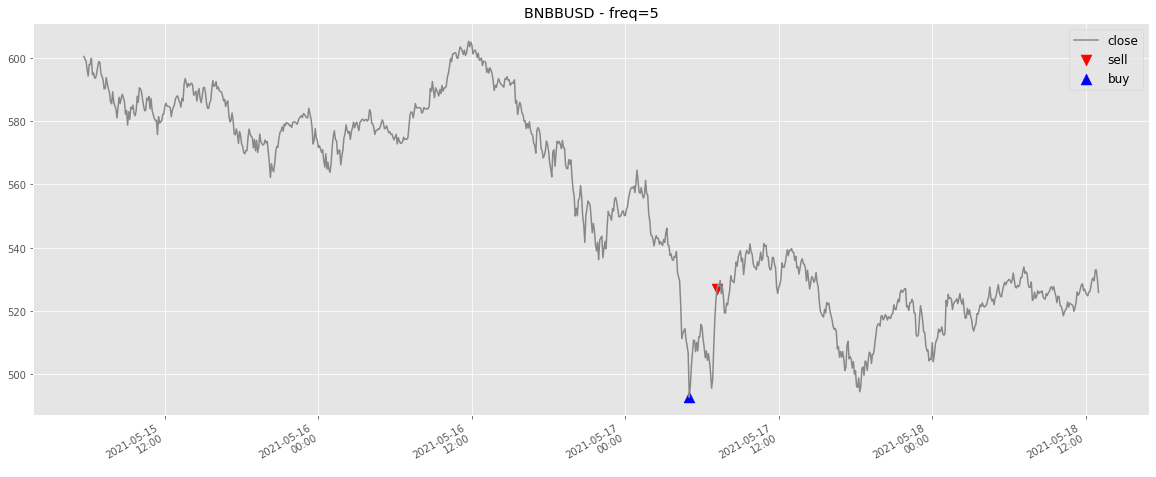

,action,rsi14,bollinger_low_norm,bollinger_high_norm,price_osc200,price_osc200_diff,macd_histo_norm,profits
2021-05-17 05:00:00,BUY,7.419380,100.667420,92.262557,0.000000,0.000,-105.183768,NaN
2021-05-17 07:10:00,SELL,75.435064,94.787657,100.459469,33.714962,3.385,131.540602,0.067962


In [13]:
from itertools import product

symbol = 'BNBBUSD'
start = '20210514130000'
freq = 5 # [30, 15, 5, 3, 1]
days = 4

# for sake of tqdm
download_history_fast(symbol, start, freq=freq, days=days)
opt = {}
for a, b in tqdm(list(product(range(0, 100 + 1, 10), range(0, 100 + 1, 10))), ncols=100, desc="Optimising parameters"):
    _, stats = single_run(symbol=symbol, start=start, freq=freq, days=days, macd_thr=[-a, b], 
                      displ=False, verbose=False)
    opt[(-a,b)] = stats['stake_hold_rate']
#         print((-a, b, stats['stake_hold_rate']))

print(f"start={start}, freq={freq}, days={days}\n\nRanking")
ranking = dict(sorted(opt.items(), key=lambda item: item[1], reverse=True)).items()
for i, (k, v) in zip(range(10), ranking):
    print(f"{v:.2f} {k}")
best_a, best_b = list(ranking)[0][0]
print(f"\nbest: {(best_a, best_b)}\n")

_ = single_run(symbol=symbol, start=start, freq=5, days=days, macd_thr=[best_a, best_b])

<img src='../../img/symbols/DOGE.png' width='96' style="vertical-align: middle;"/>

## DOGE

```
[-40, 100]
File DOGEBUSD-20210402000000-5-37.json found.
weeks 1-5: 0.737  {'stake': 8.187, 'hold': 11.11, 'profit_count': 42, 'loss_count': 23}
weeks 2-5: 0.662  {'stake': 7.096, 'hold': 10.715, 'profit_count': 42, 'loss_count': 23}
weeks 3-5: 0.854  {'stake': 3.219, 'hold': 3.768, 'profit_count': 29, 'loss_count': 22}
weeks 4-5: 1.186  {'stake': 2.95, 'hold': 2.488, 'profit_count': 15, 'loss_count': 9}
weeks 5-5: 1.028  {'stake': 2.184, 'hold': 2.124, 'profit_count': 10, 'loss_count': 4}
```

MACD thr: [-70, 100]
weeks 1-5: 0.448  {'stake_hold_rate': 0.448, 'stake': 4.979, 'hold': 11.11, 'profit_count': 40, 'loss_count': 24}
weeks 2-5: 0.413  {'stake_hold_rate': 0.413, 'stake': 4.427, 'hold': 10.715, 'profit_count': 39, 'loss_count': 24}
weeks 3-5: 0.781  {'stake_hold_rate': 0.781, 'stake': 2.941, 'hold': 3.768, 'profit_count': 30, 'loss_count': 21}
weeks 4-5: 1.250  {'stake_hold_rate': 1.25, 'stake': 3.111, 'hold': 2.488, 'profit_count': 19, 'loss_count': 6}
weeks 5-5: 1.136  {'stake_hold_rate': 1.135, 'stake': 2.412, 'hold': 2.124, 'profit_count': 11, 'loss_count': 3}
{'robustness': 40, 'potential': 0.205}


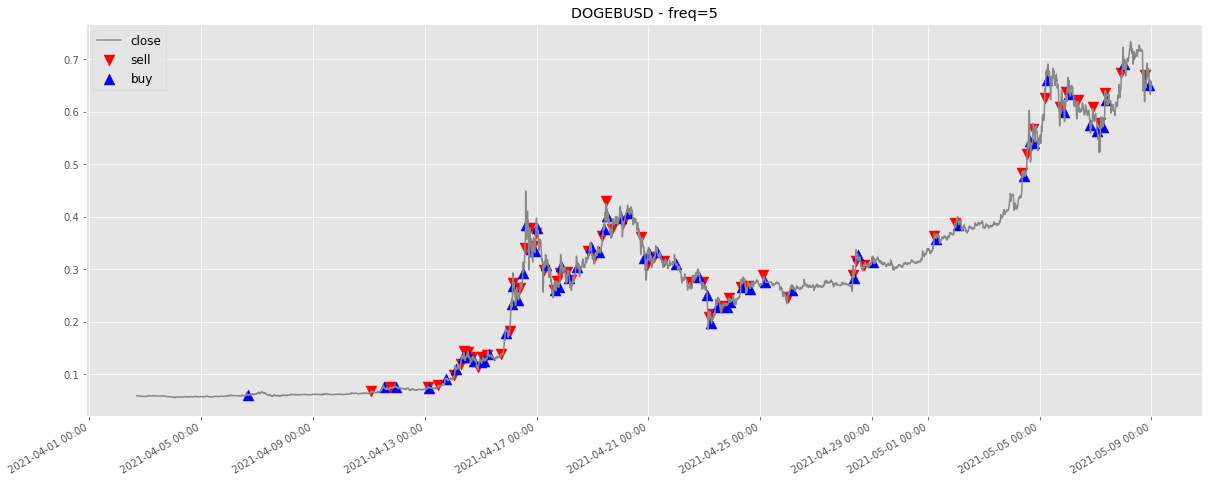

,action,rsi14,bollinger_low_norm,bollinger_high_norm,price_osc200,price_osc200_diff,macd_histo_norm,profits
2021-04-06 16:10:00,BUY,39.233766,98.072164,94.529688,25.542237,1.741,-70.249635,NaN
2021-04-11 01:50:00,SELL,95.487779,93.159836,101.806281,100.000000,0.000,124.442759,0.125884
2021-04-11 12:50:00,BUY,44.713100,95.117797,96.742888,76.698849,-9.450,-84.363995,NaN
2021-04-11 18:15:00,SELL,74.740474,94.413473,101.022560,72.833444,9.361,110.041608,-0.006243
2021-04-11 23:25:00,BUY,33.097593,99.286334,96.651748,73.010430,-0.872,-77.792054,NaN
2021-04-13 02:40:00,SELL,91.468234,94.037777,101.379939,100.000000,0.000,101.052439,0.013944
2021-04-13 04:00:00,BUY,30.963543,100.669055,97.371391,64.047279,-4.338,-75.477051,NaN
2021-04-13 11:40:00,SELL,84.099365,93.825868,101.967516,100.000000,0.000,103.071269,0.080218
2021-04-13 18:35:00,BUY,47.755643,93.171570,95.384230,81.244511,-6.539,-91.110261,NaN
2021-04-14 01:30:00,SELL,80.088393,91.343176,102.192993,100.000000,0.000,113.360355,0.112152


In [14]:
_ = study(symbol='DOGEBUSD', start=START, freq=FREQ, days=DAYS, macd_thr=[-70, 100])
# for a in range(30, 101, 10):
#     for b in range(30, 101, 10):
#         _ = study(symbol='DOGEBUSD', freq=freq, macd_thr=[-a, b], displ=False)

# Coin vs Coin

With `start,freq,days` from the simulations above.
```
d = {
    'BTCBUSD': [-60, 70],
    'BNBBUSD': [-40, 100],
    'LTCBUSD': [-50, 60],
    'DOGEBUSD': [-70, 100],
}
```

In [78]:
d = {
#     'BTCBUSD': [-60, 70],
#     'BNBBUSD': [-40, 100],
    'LTCBUSD': [-50, 60],
#     'DOGEBUSD': [-70, 100],
}

results = {}
for symbol, thr in tqdm(d.items()):
    results[symbol] = study(symbol=symbol, start='20210101000000', freq=60, days=133, 
                            macd_thr=thr, displ=False, verbose=False)
for symbol, (df, scores) in results.items():
    print(f"{symbol} MACD extrema: {(df['macd_histo_norm'].min(), df['macd_histo_norm'].max())}")
#     print(f"{symbol}: {scores}")

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]

LTCBUSD MACD extrema: (-36.31990577234812, 23.209787584188007)


MACD thr: [-60, 70]
weeks 1-5: 1.179  {'stake_hold_rate': 1.179, 'stake': 1, 'hold': 0.848, 'profit_count': 0, 'loss_count': 0}
weeks 2-5: 1.159  {'stake_hold_rate': 1.158, 'stake': 1, 'hold': 0.863, 'profit_count': 0, 'loss_count': 0}
weeks 3-5: 1.266  {'stake_hold_rate': 1.266, 'stake': 1, 'hold': 0.79, 'profit_count': 0, 'loss_count': 0}
weeks 4-5: 1.036  {'stake_hold_rate': 1.037, 'stake': 1, 'hold': 0.965, 'profit_count': 0, 'loss_count': 0}
weeks 5-5: 1.068  {'stake_hold_rate': 1.068, 'stake': 1, 'hold': 0.936, 'profit_count': 0, 'loss_count': 0}
{'robustness': 100, 'potential': 1.914}


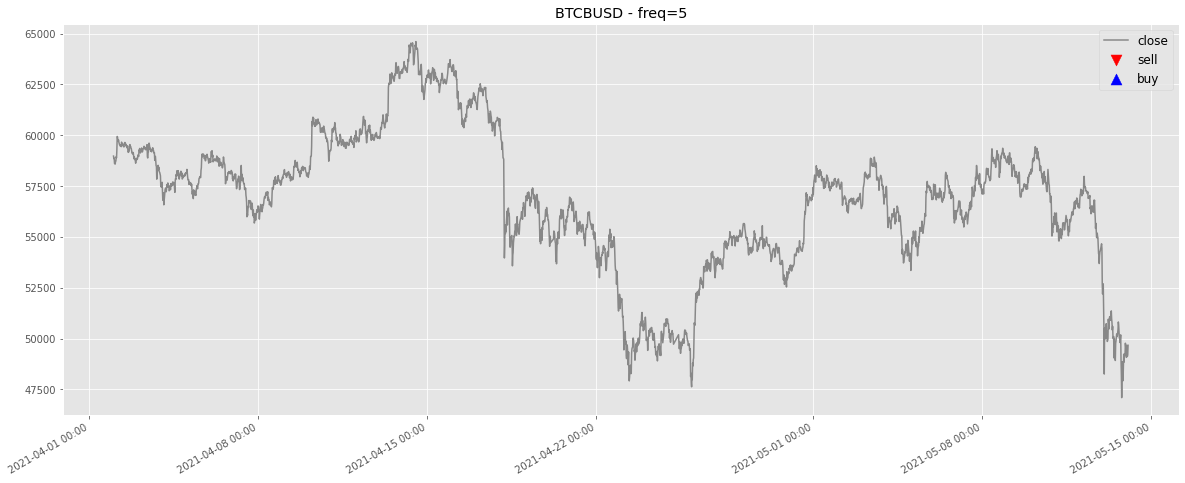

,action,rsi14,bollinger_low_norm,bollinger_high_norm,price_osc200,price_osc200_diff,macd_histo_norm,profits


In [38]:
df, scores = study(symbol='BTCBUSD', start='20210101000000', freq=5, days=133, macd_thr=[-60, 70])

# More analysis

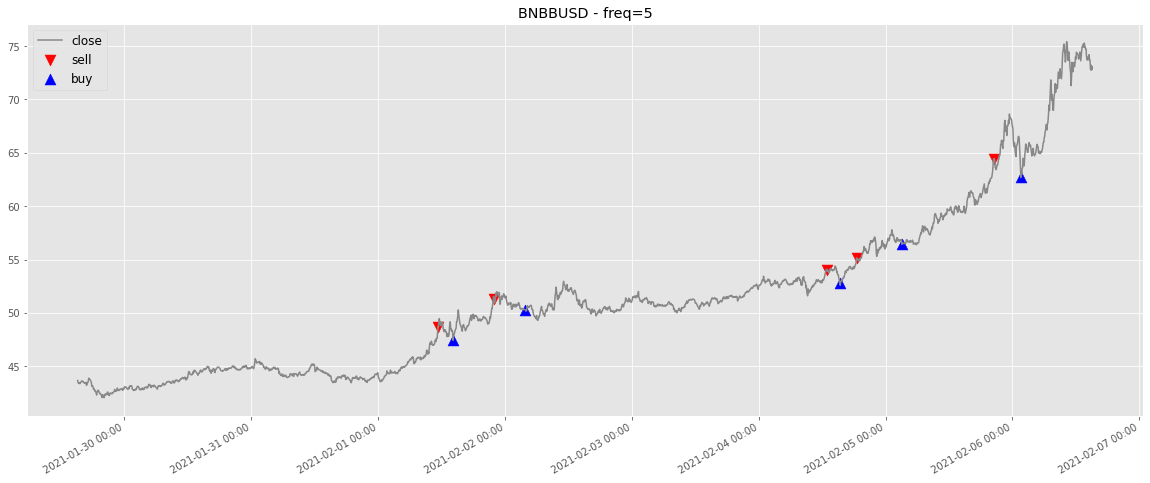

In [94]:
fold_size_in_days = 8
fold_size = int(60 / freq * 24 * fold_size_in_days)
def show_fold(i):
    fold_start = i * fold_size
    fold_end = (i+1) * fold_size
    fold = df.iloc[fold_start : fold_end].copy()
    output_chart(fold)
    
show_fold(11)

In [91]:
display_whole(df[df['action'] != '----'][['action', 'rsi14', 'bollinger_high_norm', 'price_osc200', 'price_osc200_diff', 'profits']])

,action,rsi14,bollinger_high_norm,price_osc200,price_osc200_diff,profits
2020-11-02 09:20:00,BUY,35.970768,97.834461,44.265559,-1.636,0.000000
2020-11-03 20:15:00,SELL,84.310192,100.196664,87.005917,9.751,-0.064428
2020-11-04 04:45:00,BUY,53.801420,99.653852,28.108808,4.793,0.000000
2020-11-04 17:40:00,SELL,84.387335,100.067374,100.000000,0.000,0.010717
2020-11-05 02:10:00,BUY,68.782074,99.982620,100.000000,0.456,0.000000
2020-11-05 23:10:00,SELL,84.621659,100.067888,95.513053,9.500,0.011138
2020-11-06 07:40:00,BUY,73.340379,100.114595,97.684829,-0.553,0.000000
2020-11-06 10:25:00,SELL,83.499133,100.130625,100.000000,0.000,0.008037
2020-11-06 18:55:00,BUY,36.512761,99.422781,63.567444,-0.064,0.000000
2020-11-07 00:20:00,SELL,83.368590,100.197686,91.811658,6.547,0.012964


In [42]:
display_whole(df.iloc[:200][['close', 'rsi14', 'action']])

,close,rsi14,action
2020-11-01 16:40:00,28.1700,37.824997,BUY
2020-11-01 16:45:00,28.1814,42.553842,----
2020-11-01 16:50:00,28.1883,45.451291,----
2020-11-01 16:55:00,28.1796,42.344114,----
2020-11-01 17:00:00,28.1624,36.631537,----
2020-11-01 17:05:00,28.1599,35.821067,----
2020-11-01 17:10:00,28.1451,31.118170,----
2020-11-01 17:15:00,28.1833,50.480345,----
2020-11-01 17:20:00,28.2600,70.010307,----
2020-11-01 17:25:00,28.1612,44.137596,----


<AxesSubplot:ylabel='Frequency'>

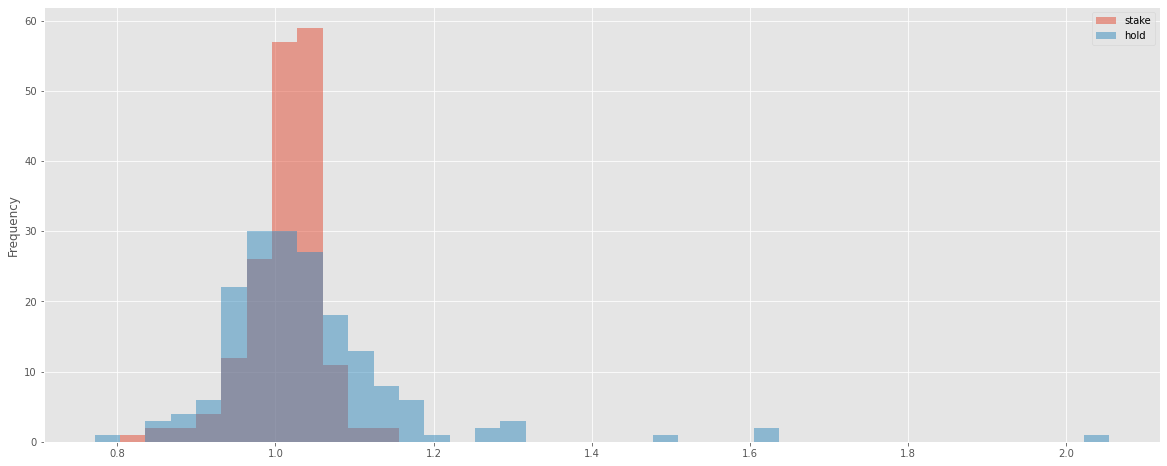

In [259]:
df_stats[['stake', 'hold']].plot(kind='hist', bins=40, alpha=0.5)

In [203]:
f"{len(df[(df['rsi14'] <= 30) & (df['bollinger_low_norm'] > 95) & (df['price_osc200'] < 30)])/days:.3f} per day"

'14.272 per day'

In [105]:
# plot(plt.plot, df, ['close', 'price_osc200'], [None] * 2)

In [78]:
# fold_size_in_days = 8
# fold_size = int(60 / freq * 24 * fold_size_in_days)
# n_folds = round(len(df) / fold_size)
# print(f"n_folds: {2 * n_folds}\n")

# df_stats = pd.DataFrame(columns=['stake', 'hold', 'stake_hold_ratio', 'profit_count', 'loss_count'])
# folds = []
# for k in [0, int(fold_size / 2)]:
#     for i in range(0, n_folds):
#         fold_start = i * fold_size + k
#         fold_end = (i+1) * fold_size + k
#         fold = df.iloc[fold_start : fold_end].copy()
#         if len(fold) < fold_size / 2:
#             continue
#         fold, stats = simulate(fold)
#         stats['stake_hold_ratio'] = stats['stake'] / stats['hold']
#         df_stats = df_stats.append(stats, ignore_index=True)
#         folds.append({'fold': fold, 'stats': stats})

# print(df_stats[['stake_hold_ratio', 'profit_count', 'loss_count']].describe())

# chart = df_stats['stake_hold_ratio'].plot(kind='hist', bins=30)
# title = f"{symbol}-{start}-{freq}-{days}-{strategy}-stake_hold_ratio"
# chart.set_title(title.replace("-", " "))
# chart.figure.savefig(f"{title}.png")

In [106]:
display_whole(df.iloc[:200][['close', 'rsi14', 'action']])

,close,rsi14,action
2021-04-13 09:10:00,558.0140,63.512028,----
2021-04-13 09:15:00,554.3182,54.442904,----
2021-04-13 09:20:00,544.4056,37.757423,----
2021-04-13 09:25:00,544.5596,38.097507,----
2021-04-13 09:30:00,538.8837,30.914273,----
2021-04-13 09:35:00,532.5365,24.864954,----
2021-04-13 09:40:00,535.0668,31.069324,----
2021-04-13 09:45:00,541.0229,43.697027,----
2021-04-13 09:50:00,541.5712,44.771704,----
2021-04-13 09:55:00,539.2438,40.944008,----


In [108]:
display_whole(df[df['action'] != '----'][['close', 'rsi14', 'action']])

,close,rsi14,action
2021-04-14 04:00:00,557.5340,19.570571,BUY
2021-04-14 04:05:00,559.0569,36.071158,SELL
2021-04-14 10:20:00,565.1000,19.812452,BUY
2021-04-14 10:25:00,566.5673,25.090350,SELL
2021-04-14 15:05:00,540.4442,13.103099,BUY
2021-04-14 15:10:00,523.5955,7.719694,SELL
2021-04-14 20:20:00,530.2968,18.591187,BUY
2021-04-14 20:25:00,530.8831,21.368509,SELL
2021-04-14 20:30:00,527.7303,17.635443,BUY
2021-04-14 20:35:00,532.6662,37.392965,SELL


MACD thr: [-100, 100]
weeks 1-5: 1.410  {'stake_hold_rate': 1.41, 'stake': 1.707, 'hold': 1.211, 'profit_count': 12, 'loss_count': 2}
{'robustness': 100, 'potential': 1.41}


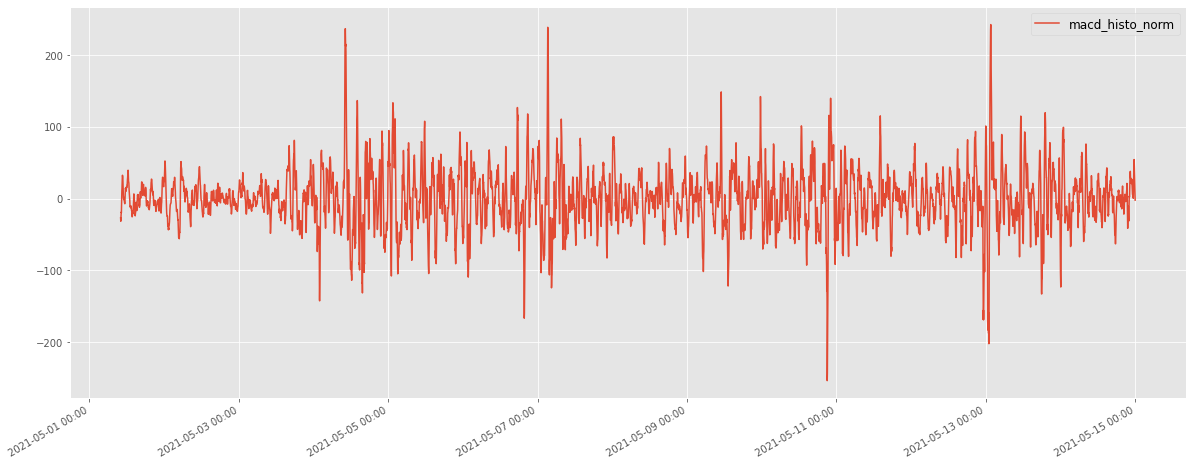

In [255]:
df, scores = study(symbol=symbol, start='20210501000000', freq=3, days=14, macd_thr=[-100, 100], displ=False)
plot(plt.plot, df, ['macd_histo_norm'], [None])